In [44]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [24]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [25]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'energy used'}, xlabel='Datetime'>

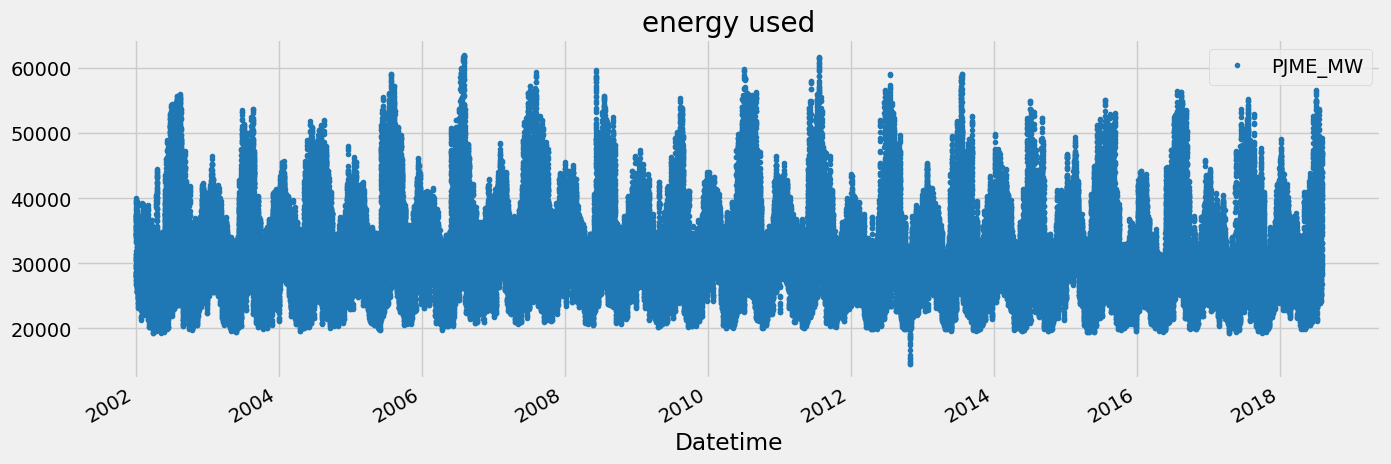

In [26]:
df.plot(style='.', figsize=(15,5), color = color_pal[0], title='energy used')

In [22]:
df.columns

Index(['PJME_MW'], dtype='object')

In [23]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

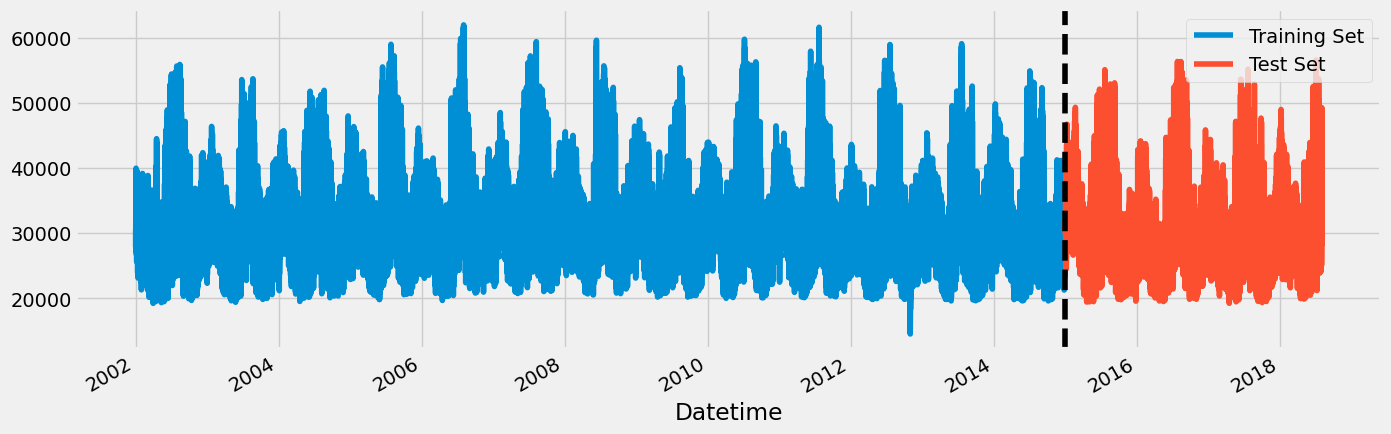

In [28]:
# train testt
train = df.loc [df.index < '01-01-2015']
test = df.loc[df.index>= '01-01-2015'] 

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training set')
test.plot(ax=ax, label='Test set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend (['Training Set','Test Set'])
plt.show()


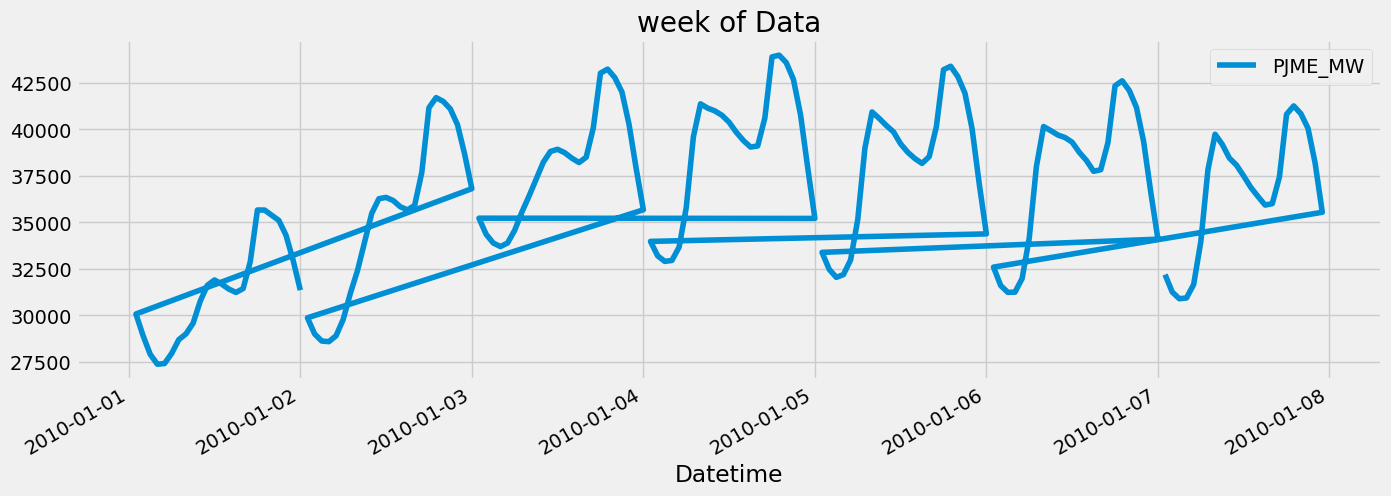

In [33]:
df.loc[(df.index > '01-01-2010')&(df.index<'01-08-2010')].plot(figsize=(15,5), title='week of Data')
plt.show()

In [35]:
#feature creations
df.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
      dtype='int32', name='Datetime', length=145366)

In [36]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week

In [37]:
df.head()

,PJME_MW,hour,dayofweek
Datetime,,,
2002-12-31 01:00:00,26498.0,1,1
2002-12-31 02:00:00,25147.0,2,1
2002-12-31 03:00:00,24574.0,3,1
2002-12-31 04:00:00,24393.0,4,1
2002-12-31 05:00:00,24860.0,5,1


In [47]:
#feature creation#
def create_features(df):
    df = df.copy()
    df['hour']=df.index.hour 
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year']=df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

<function matplotlib.pyplot.show(close=None, block=None)>

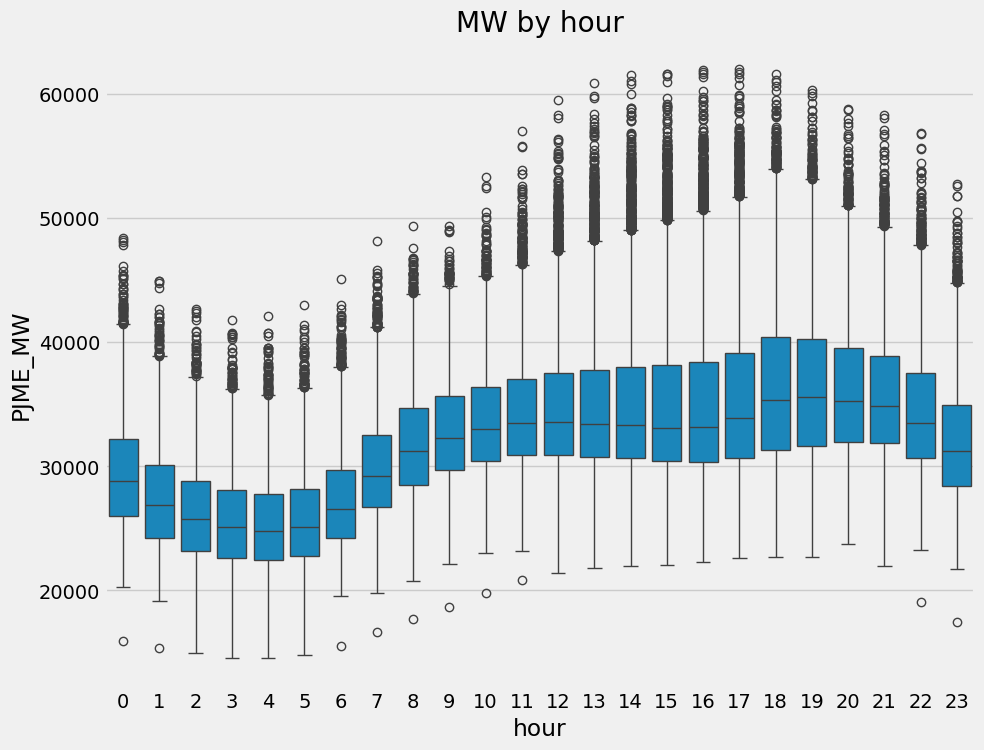

In [43]:
#vizualizes
fig, ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')
plt.show

In [51]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'PJME_MW'

In [48]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [52]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [57]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50, learning_rate = 0.01 )
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
reg.feature_importances_

array([0.46387812, 0.1620048 , 0.02888114, 0.20316096, 0.02382433,
       0.11825063], dtype=float32)

In [59]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

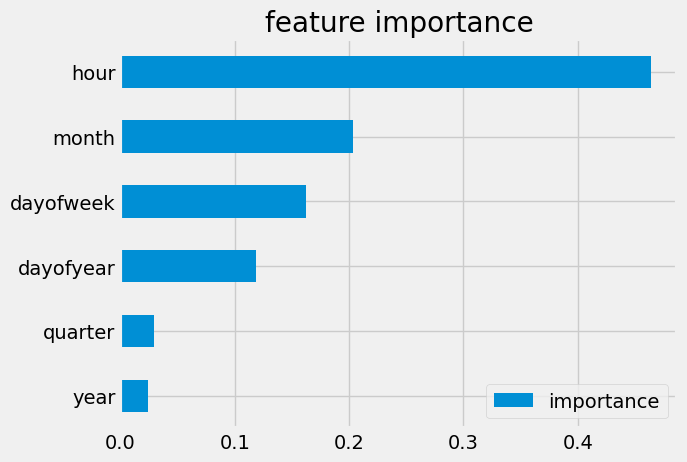

In [60]:
fi.sort_values('importance').plot(kind='barh', title='feature importance')
plt.show()

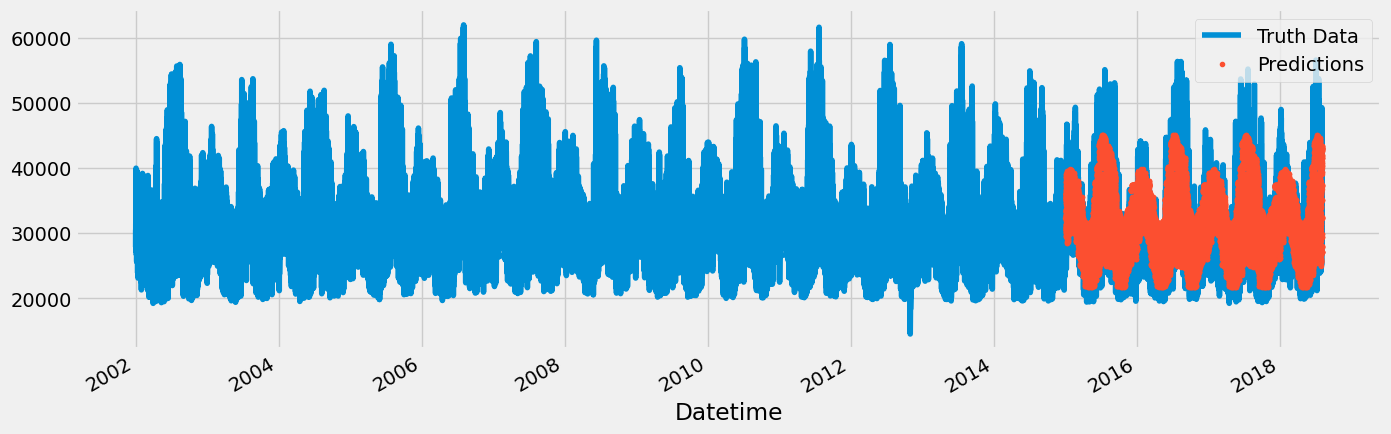

In [69]:
#forecast on test
test['predictions']=reg.predict(X_test)
df=df.merge(test[['predictions']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

In [67]:
df.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,predictions
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN


In [71]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 3741.03


In [72]:
test['error']=np.abs(test[TARGET] - test['predictions'])

In [73]:
#vorste and best predicted dates
test['date']=test.index.date 

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5) # worst predicted dates

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [77]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5) # best predicted dates

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64